**Cloning Github Repository**

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import files
import zipfile
import os


In [3]:
zip_path = "/content/dataset[1].zip"  # Change this to the actual filename

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")  # Extract to a directory


In [4]:
# Define dataset paths
dataset_path = "/content/dataset"
positive_dir = os.path.join(dataset_path, "Positive")  # Crack images
negative_dir = os.path.join(dataset_path, "Negative")  # No-crack images

# Get all image paths
crack_images = glob(os.path.join(positive_dir, "*.jpg"))
no_crack_images = glob(os.path.join(negative_dir, "*.jpg"))

# Print dataset info
print(f"Total Crack Images: {len(crack_images)}")
print(f"Total No-Crack Images: {len(no_crack_images)}")


Total Crack Images: 20000
Total No-Crack Images: 20000


<ipython-input-5-7a83c103eb35>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="coolwarm")


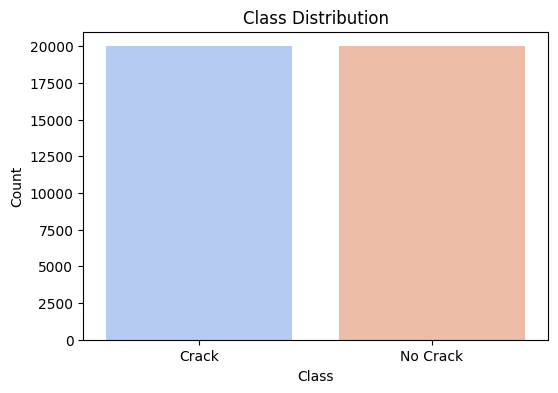

In [5]:
labels = ['Crack'] * len(crack_images) + ['No Crack'] * len(no_crack_images)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels, palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Checking Image Sizes**

Average Image Width: 227.00, Height: 227.00


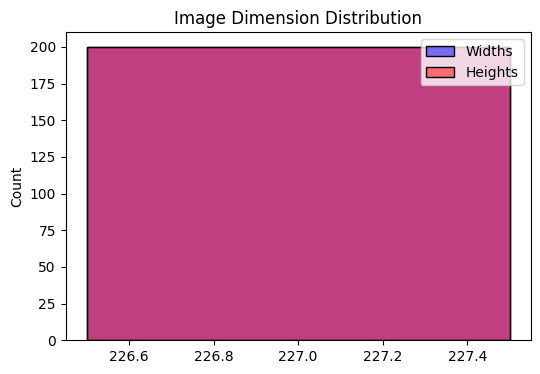

In [6]:
image_sizes = []
for img_path in crack_images[:100] + no_crack_images[:100]:  # Checking 100 images per class
    img = Image.open(img_path)
    image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
print(f"Average Image Width: {np.mean(widths):.2f}, Height: {np.mean(heights):.2f}")

plt.figure(figsize=(6, 4))
sns.histplot(widths, kde=True, color="blue", label="Widths")
sns.histplot(heights, kde=True, color="red", label="Heights")
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()


**Compute Image Stats(Mean & Std)**

In [7]:
def calculate_stats(image_list):
    means, stds = [], []

    for img_path in image_list[:500]:  # Checking first 500 images
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize
        means.append(np.mean(img))
        stds.append(np.std(img))

    return np.mean(means), np.mean(stds)

crack_mean, crack_std = calculate_stats(crack_images)
no_crack_mean, no_crack_std = calculate_stats(no_crack_images)

print(f"Crack Images - Mean: {crack_mean:.3f}, Std: {crack_std:.3f}")
print(f"No Crack Images - Mean: {no_crack_mean:.3f}, Std: {no_crack_std:.3f}")


Crack Images - Mean: 0.645, Std: 0.122
No Crack Images - Mean: 0.718, Std: 0.033


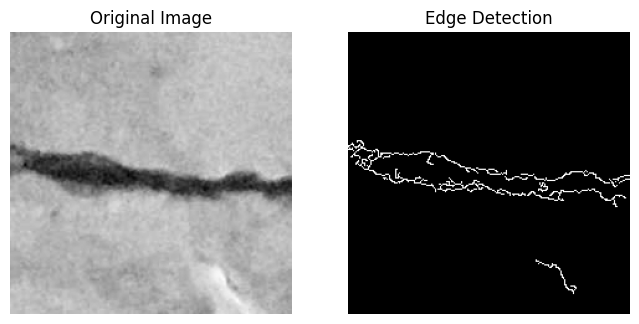

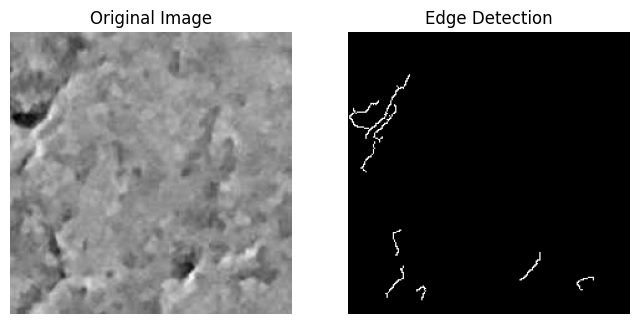

In [8]:
def show_edges(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge Detection")
    plt.axis("off")

    plt.show()

# Test edge detection
show_edges(crack_images[0])
show_edges(no_crack_images[0])


📌 Preprocessing Steps

1️⃣ Load images & resize (Ensure all images have the same shape)

2️⃣ Convert to grayscale (optional)

3️⃣ Normalize pixel values (Scale values between 0-1 or -1 to 1)

4️⃣ Data Augmentation (Flip, rotate, zoom, etc.)

5️⃣ Prepare for model training (Create train-test splits & format data)



In [9]:
IMG_SIZE = (128, 128)  # ⬅️ Smaller = faster
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Train generator (augmented)
train_augmented = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Validation generator (no shuffle for evaluation)
val_data = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


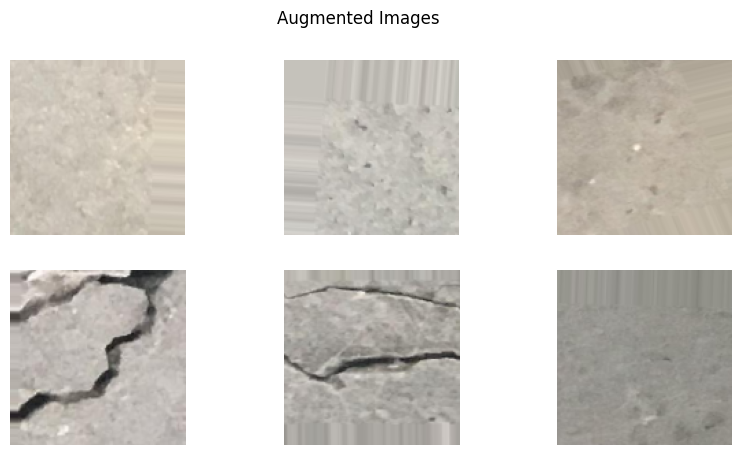

In [10]:
import matplotlib.pyplot as plt

augmented_images, _ = next(train_augmented)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()


**Simple CNN**

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

dropout_rates = [0.3, 0.5]
l2_vals = [0.0001, 0.001]
learning_rates = [0.0001, 0.0004]

best_val_acc = 0
best_model = None
best_params = {}

for d in dropout_rates:
    for l2 in l2_vals:
        for lr in learning_rates:
            print(f"\n Training with Dropout={d}, L2={l2}, LR={lr}")

            model = models.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3),
                              kernel_regularizer=regularizers.l2(l2)),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(d),

                layers.Conv2D(64, (3, 3), activation='relu',
                              kernel_regularizer=regularizers.l2(l2)),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(d),

                layers.Conv2D(128, (3, 3), activation='relu',
                              kernel_regularizer=regularizers.l2(l2)),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(d),

                layers.Flatten(),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(1, activation='sigmoid')
            ])

            model.compile(
                optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )

            checkpoint_callback = ModelCheckpoint(
                filepath="best_model.weights.h5",
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=True,
                verbose=1
            )

            early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

            history = model.fit(
                train_augmented,
                validation_data=val_data,
                epochs=10,  
                steps_per_epoch=100,
                validation_steps=50,
                callbacks=[checkpoint_callback, early_stopping],
                verbose=1
            )
            val_acc = history.history['val_accuracy'][-1]
            print(f" Val Accuracy: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model
                best_params = {'dropout': d, 'l2': l2, 'lr': lr}

print("\n Best Params:", best_params)
print(f" Best Validation Accuracy: {best_val_acc:.4f}")


 Training with Dropout=0.3, L2=0.0001, LR=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5136 - loss: 0.7254
Epoch 1: val_accuracy improved from -inf to 0.24062, saving model to best_model.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.5135 - loss: 0.7253 - val_accuracy: 0.2406 - val_loss: 0.7063
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4966 - loss: 0.7069
Epoch 2: val_accuracy improved from 0.24062 to 1.00000, saving model to best_model.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.4967 - loss: 0.7069 - val_accuracy: 1.0000 - val_loss: 0.6970
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5453 - loss: 0.7012
Epoch 3: val_accuracy did not improve from 1.00000
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.5451 - loss: 0.7012 - val_accuracy: 0.9987 - val_loss: 0.6931
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5448 - loss: 0.6963
Epoch 4: val_accuracy did not improve from 1.00000
1

In [ ]:
#  Use best parameters found from grid search
best_dropout = best_params['dropout']
best_l2 = best_params['l2']
best_lr = best_params['lr']

final_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3),
                  kernel_regularizer=regularizers.l2(best_l2)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(best_dropout),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(best_l2)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(best_dropout),

    layers.Conv2D(128, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(best_l2)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(best_dropout),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

final_model.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
final_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath="final_best_model.weights.h5",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

final_history = final_model.fit(
    train_augmented,
    validation_data=val_data,
    epochs=30,
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5616 - loss: 0.7636
Epoch 1: val_accuracy improved from -inf to 0.98100, saving model to final_best_model.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 182s 177ms/step - accuracy: 0.5618 - loss: 0.7635 - val_accuracy: 0.9810 - val_loss: 0.2468
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9709 - loss: 0.1895
Epoch 2: val_accuracy improved from 0.98100 to 0.98362, saving model to final_best_model.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 176s 176ms/step - accuracy: 0.9709 - loss: 0.1895 - val_accuracy: 0.9836 - val_loss: 0.1684
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9755 - loss: 0.1443
Epoch 3: val_accuracy did not improve from 0.98362
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 185s 185ms/step - accuracy: 0.9755 - loss: 0.1443 - val_accuracy: 0.9816 - val_loss: 0.1436
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9792 - loss: 0.1199
Epoch 4: val_accuracy i

**Saving the model**

In [14]:
#from google.colab import drive
#drive.mount('/content/drive')

#model.save("/content/drive/My Drive/Augmented_data_cnn_trained_model_3.h5")
model.save("Augmented_data_cnn_trained_model_2.h5")
print("Model saved successfully!")

Model saved successfully!


**Accuracy value**

In [19]:
print("Accuracy:", final_history.history['accuracy'][-1])
print("Validation Accuracy:", final_history.history['val_accuracy'][-1])


Accuracy: 0.9927187561988831
Validation Accuracy: 0.9972500205039978


**Plotting Model Accuracy and Loss**

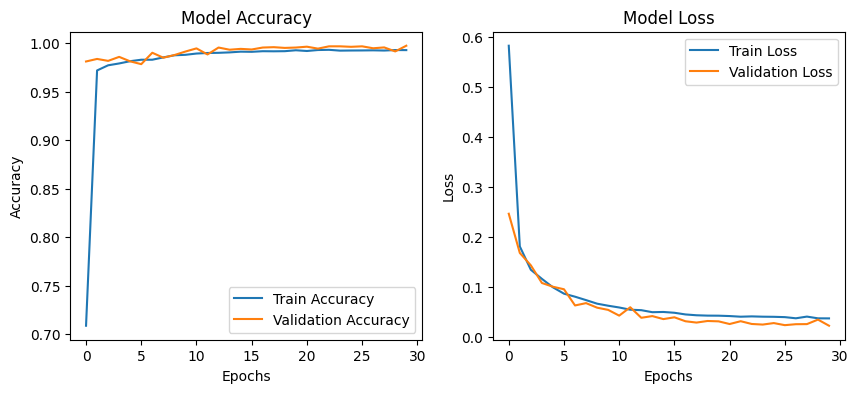

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(final_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = val_data.classes

# Predict on validation data
y_pred_probs = final_model.predict(val_data)
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))


250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step
              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00      4000
    Positive       1.00      0.99      1.00      4000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



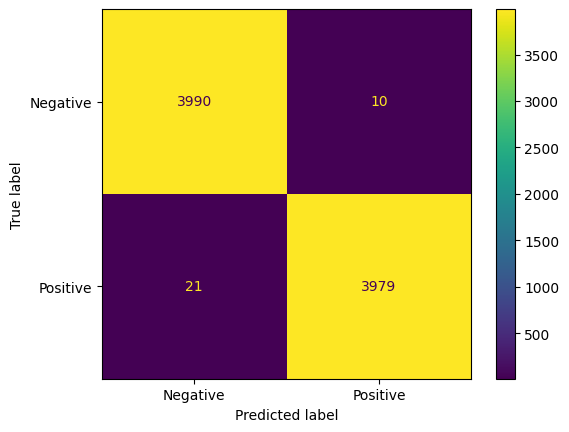

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
disp.plot()
plt.show()
